In [1]:
# Import necessary packages
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [2]:
# Check the current working directory
os.getcwd()

'C:\\Users\\yikun.sun\\Desktop\\Python\\Titanic Survival'

In [3]:
# Read in both the training and testing data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [4]:
# Take a look at the first few records to get familiar with each field
# Name and Ticket don't seem to have a strong relationship with the survival rate.
# Let's keep them in the dataset for now and maybe drop them later if there are many missing values.
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
# Check the number of rows and columns in training data
train.shape

(891, 12)

In [6]:
# Check the number of rows and columns in testing data
test.shape

(418, 11)

In [7]:
# Build a function to check for missing values in a dataset
def sum_missing(df):
    missing = df.isnull().sum().sort_values(ascending=False)
    percent = round(100*df.isnull().sum()/df.isnull().count(),1).sort_values(ascending=False)
    missing_data = pd.concat([missing, percent], axis=1, keys=['Count', 'Percent'])
    return missing_data

In [8]:
# Check for missing values in training and testing data
print(sum_missing(train))
print(sum_missing(test))

             Count  Percent
Cabin          687     77.1
Age            177     19.9
Embarked         2      0.2
PassengerId      0      0.0
Survived         0      0.0
Pclass           0      0.0
Name             0      0.0
Sex              0      0.0
SibSp            0      0.0
Parch            0      0.0
Ticket           0      0.0
Fare             0      0.0
             Count  Percent
Cabin          327     78.2
Age             86     20.6
Fare             1      0.2
PassengerId      0      0.0
Pclass           0      0.0
Name             0      0.0
Sex              0      0.0
SibSp            0      0.0
Parch            0      0.0
Ticket           0      0.0
Embarked         0      0.0


In [9]:
# Cabin has more than 75% missing data in both training and testing data. 
# Due to the huge amount of missing values, usually imputing doesn't produce good results, so let's drop is in both datasets.
train = train.drop(['Cabin'], axis=1)
test = test.drop(['Cabin'], axis=1)

In [10]:
# Besides Age, there are 2 missing values for Embarked in training data, which only represent 0.2% of the whole dataset.
# So we can drop the 2 missing values.
# We will impute missing values in Age later after EDA because Age might be correlated with other variables.
# If we impute Age with mean value, that might mask the correlation between Age and other variables. 
train.dropna(subset=['Embarked'], inplace=True)

In [11]:
# Pclass, Sex, SibSp, Parch, Embarked seem to have a strong relationship with the chance of surviving.
# Let's go through each variable to see if the survival rate differs among the levels.
# We will go through Age and Fare later since these continuous variables have a broader range.

# Upper class passengers' survival rate > Middle class passengers' > Lower class passengers'
train[['Pclass', 'Survived']].groupby('Pclass').mean().reset_index()

,Pclass,Survived
0,1,0.626168
1,2,0.472826
2,3,0.242363


In [12]:
# Female passengers are much more likely to survive than male passengers
train[['Sex', 'Survived']].groupby('Sex').mean().reset_index()

,Sex,Survived
0,female,0.740385
1,male,0.188908


In [13]:
# Survival rate increases when the # of siblings and spouses increases to 1 from 0.
# However, the rate decreases as passengers have more siblings and spouses.
# None of the passengers with 5 or 8 siblings and spouses survived, 
# which means passengers with a huge family have much lower survival rate than those with a small family.
train[['SibSp', 'Survived']].groupby('SibSp').mean().reset_index()

,SibSp,Survived
0,0,0.343234
1,1,0.535885
2,2,0.464286
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [14]:
# Passengers with 1, 2, 3 parents and children are more likely to survive than passengers without any parents or children.
# This makes sense because the old and the young would be helped first.
# Passengers with 3 parents and children have highest survival rate. 
# However, when passengers have a bigger family, such as 4, 5, 6 parents or children, their likelihood to survive decreases. 
# This observation matches what we just observed from the relationship between SibSp and Survived
train[['Parch', 'Survived']].groupby('Parch').mean().reset_index()

,Parch,Survived
0,0,0.341716
1,1,0.550847
2,2,0.500000
3,3,0.600000
4,4,0.000000
5,5,0.200000
6,6,0.000000


In [15]:
# Passengers who embarked in Cherbourg have a higher survival rate than Queenstown, 
# whose survival rate is higher than Southampton.
train[['Embarked', 'Survived']].groupby('Embarked').mean().reset_index()

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.336957


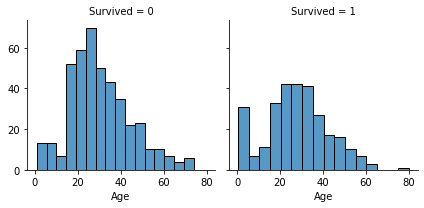

In [16]:
# Let's visualize the relationship between Age and Survived
# More kids between 0 and 10 years old survived than those who didn't
# More adults between 20 and 60 died than those survived
# There seems to be a negative relationship between Age and Survived
sns.FacetGrid(train, col = 'Survived').map(sns.histplot, 'Age')
plt.show()

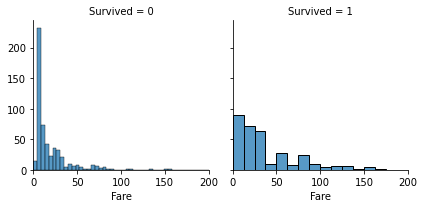

In [17]:
# Let's see if Fare plays a role in the survival rate
# Survival rate for passengers with $0-$50 is much lower than that for passengers with $50-$150
# Set x axis between 0 and 200, because there's few guests paid over $200 and for easier comparison
fig = sns.FacetGrid(train, col = 'Survived', xlim=(0,200)).map(sns.histplot, 'Fare')

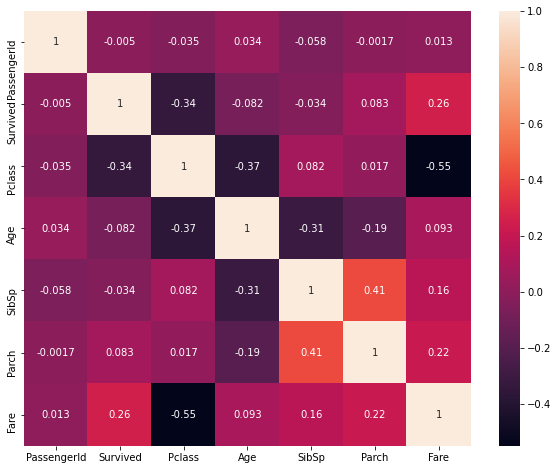

In [18]:
# Use a heatmap to see each variable's relationship with Survived
# Similar to what we observed, Pclass, Age, SibSp all have a negative relationship with Survived
# Fare and Parch have a positive relationship with Survived
# All these variables should be included in the model
f, ax = plt.subplots(figsize=(10,8))
sns.heatmap(train.corr(), annot=True)
plt.show()

In [19]:
# Data Cleaning and Feature Engineering start here
# In the current dataset, we are certain that PassengerId and Ticket won't be included in the model since they barely help us predict the survival
# Let's drop these columns from the dataset
train.drop(['PassengerId', 'Ticket'], axis = 1, inplace = True)
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S


In [20]:
# Repeat same step for testing data 
# In order to upload the results onto Kaggle, we need to store the PassengerId
test_id = test.PassengerId
test.drop(['PassengerId', 'Ticket'], axis = 1, inplace = True)
test.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,"Kelly, Mr. James",male,34.5,0,0,7.8292,Q
1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,7.0000,S
2,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,9.6875,Q
3,3,"Wirz, Mr. Albert",male,27.0,0,0,8.6625,S
4,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,12.2875,S


In [21]:
# Besides Name, we still have Sex and Embarked as categorical variables. 
# We should apply one hot encoding to these two features since they are nominal variables.
# There's no intrinsic rankings between Male and Female or among different embarkations.
# Define a function to one hot encode categorical features, such as Sex and Embarked
def one_hot_encode(df, column):
    dummy = pd.get_dummies(df[column])
    df = df.drop(column, axis=1)
    df = df.join(dummy)
    return df

In [22]:
# One hot encode Sex and Embarked in both training and testing data
train = one_hot_encode(train, 'Sex')
train = one_hot_encode(train, 'Embarked')
test = one_hot_encode(test, 'Sex')
test = one_hot_encode(test, 'Embarked')

In [23]:
# We can drop the male column, since we can tell if a passenger is male or not by female feature.
# When female is 0, it's a male passenger. When female is 1, the passenger is female.
# We can also drop the S column. When both C and Q are 0, the passenger embarked at S.
train.drop(['male', 'S'], axis=1, inplace=True)
test.drop(['male', 'S'], axis=1, inplace=True)

In [24]:
# The only remaining column in the string type is Name.
# Passenger name doesn't help make predictions. However, the title associated with each name might be helpful.
# Therefore, we should add another feature into our model, Title. Let's extract title from Name.
train['Title'] = train['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

# There are four major titles, Mr, Miss, Mrs, Master.
train.Title.value_counts()/train.Title.count()*100

# Let's combine other titles into one category called Other
train.Title = train.Title.replace(list(train.Title.value_counts()[4:].index), 'Other')

# After adding the column Title, we can drop Name from the dataset
train.drop(['Name'], axis=1, inplace=True)

In [25]:
# Let's take a look at the average survival rate for each title
# The goal here is to replace categorical values with numerical values
pd.DataFrame(train.groupby(['Title']).Survived.mean()).reset_index().sort_values(by='Survived', ascending=False)

,Title,Survived
3,Mrs,0.790323
1,Miss,0.696133
0,Master,0.575000
4,Other,0.444444
2,Mr,0.156673


In [26]:
# One hot encode Title
train = one_hot_encode(train, 'Title')

In [27]:
# Repeat same step for testing data
test['Title'] = test['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
test.Title = test.Title.replace(list(test.Title.value_counts()[4:].index), 'Other')
test.drop(['Name'], axis=1, inplace=True)
test = one_hot_encode(test, 'Title')

In [28]:
# Let's set title "Other" as default in both training and testing data
train.drop(['Other'], axis=1, inplace=True)
test.drop(['Other'], axis=1, inplace=True)

In [29]:
# For the missing values in Age, let's fill them with mean for now.
# If the accuracy doesn't fulfill our expectations, we can come back and replace missing values in Age based on values in other fields
train.Age.fillna(train.Age.mean(), inplace = True)
test.Age.fillna(test.Age.mean(), inplace = True)

In [30]:
# Before the modeling process, there's still one missing value for Fare in testing data.
# Becasue there's a strong correlation between Fare and Pclass, let's replace this missing value with the mean fare for that Pclass
test[test['Fare'].isnull()] = test.groupby('Pclass').Fare.mean()[3]

In [31]:
# We are done with the feature selecting and engineering step. 
# However, if our models generate an accuracy score lower than expected, we may need to select and engineer features again.
# Here begins the modeling and predicting part.
# Because the goal here is to predict if a passenger survived or not, and our target variable is binary, we should only consider classification algorithms.
# We will use the following machine learning algorithms:
# Logistic Regression
# KNN
# Decision Tree
# Random Forest
# XGBoost

# Let's split the training data into training and testing in order to check the accuracy of our model
x = train.drop(['Survived'], axis=1)
y = train['Survived']
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size = 0.2, random_state=0)

In [32]:
# Let's implement Logistic Regression first, from which we can tell each variable's coefficient to see if it's positively or negatively associated with the target variable, and how much influential it is.
# Firstly, ignore warnings, or Python would keep showing warnings if we don't specify the "max_iter" argument for Logistic Regression
warnings.filterwarnings("ignore")

# Build a for loop to choose the optimal value for max_iter to get the best accuracy score
for i in [10, 20, 30, 40, 50]:
    log_reg = LogisticRegression(max_iter = i)
    log_reg.fit(train_x, train_y)
    print("Accuracy with iterations {}: {}".format(i, log_reg.score(test_x, test_y)))

Accuracy with iterations 10: 0.7359550561797753
Accuracy with iterations 20: 0.7303370786516854
Accuracy with iterations 30: 0.7359550561797753
Accuracy with iterations 40: 0.7584269662921348
Accuracy with iterations 50: 0.7528089887640449


In [33]:
# When iterations reached 40, the accuracy score stopped improving, so we should set max_iter to 40
# The accuracy score of the logistic regression model on training data was 84.1%
# While the score on testing data was 75.8%. 
log_reg = LogisticRegression(max_iter = 40)
log_reg.fit(train_x, train_y)
print("Accuracy with Logistic Regression on training data: {:.1f}%".format(100*log_reg.score(train_x, train_y)))
print("Accuracy with Logistic Regression on testing data: {:.1f}%".format(100*log_reg.score(test_x, test_y)))
log_reg_accuracy = round(100*log_reg.score(test_x, test_y), 2)

Accuracy with Logistic Regression on training data: 84.1%
Accuracy with Logistic Regression on testing data: 75.8%


In [34]:
# Combine Features and their corresponding coefficients into a DataFrame
# Master has the highest coefficient, meaning the probability of surviving increases most when passengers are titled "Master".
# This is what we expected since young children has a higher survival rate than adults.
# Feature with the second highest coefficient is female, meaning female passengers are more likly to survive than male passengers.
# Passengers embarked at Q and C are more likely to survive than those embarked at S.
# As the family size increases, the chance to survive decreases.
# Male adults is the group of passengers with lower probability to survive compared to kids and female passengers.
log_results = pd.DataFrame(log_reg.coef_[0], train_x.columns, columns=['Coefficient']).reset_index()
log_results = log_results.rename(columns={'index': 'Feature'}).sort_values(by='Coefficient', ascending=False)
log_results

,Feature,Coefficient
5,female,1.520752
8,Master,1.193899
11,Mrs,1.055750
6,C,0.857929
7,Q,0.436714
9,Miss,0.249164
4,Fare,0.007366
1,Age,-0.019732
2,SibSp,-0.241621
3,Parch,-0.485205


In [35]:
# Based on the results, it seems that Fare has a very small influence on the survival rate. Therefore, let's drop Fare and see if the accuracy improved or not.
nofare = ['Pclass', 'Age', 'SibSp', 'Parch', 'female', 'C', 'Q', 'Master', 'Miss', 'Mr', 'Mrs']
for i in [10, 20, 30, 40, 50]:
    log_reg_nofare = LogisticRegression(max_iter = i)
    log_reg_nofare.fit(train_x[nofare], train_y)
    print("Accuracy with iterations {}: {}".format(i, log_reg_nofare.score(test_x[nofare], test_y)))

Accuracy with iterations 10: 0.7359550561797753
Accuracy with iterations 20: 0.7303370786516854
Accuracy with iterations 30: 0.7359550561797753
Accuracy with iterations 40: 0.7528089887640449
Accuracy with iterations 50: 0.7415730337078652


In [36]:
# With 40 iterations, we get the best accuracy.
# The accuracy score on training data almost stays same, while the score decreases a little on testing data. 
# Therefore, we should stick with the model including Fare
log_reg_nofare = LogisticRegression(max_iter = 40)
log_reg_nofare.fit(train_x[nofare], train_y)
print("Accuracy with Logistic Regression on training data: {:.1f}%".format(100*log_reg_nofare.score(train_x[nofare], train_y)))
print("Accuracy with Logistic Regression on testing data: {:.1f}%".format(100*log_reg_nofare.score(test_x[nofare], test_y)))

Accuracy with Logistic Regression on training data: 84.2%
Accuracy with Logistic Regression on testing data: 75.3%


In [37]:
# Next model we will implement is KNN, k-Nearest Neighbors, which is a supervised machine learning algorithm used for classification and regression.
# KNN assumes that similar things exist in close proximity. In our case, the survived passengers should have some similar characteristics.
# One important parameter to adjust here is n_neighbors, which highly determines the accuracy of our model.
# n_neighbors specify the number of neighbors to use. 
# Let's use a for loop to pick the optimal value for n_neighbors
for i in range(1, 6):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(train_x, train_y)
    print("Accuracy with {} neighbors is {:.2%} on training data".format(i, knn.score(train_x, train_y)))
    print("Accuracy with {} neighbors is {:.2%} on testing data".format(i, knn.score(test_x, test_y)))

Accuracy with 1 neighbors is 98.31% on training data
Accuracy with 1 neighbors is 69.66% on testing data
Accuracy with 2 neighbors is 85.09% on training data
Accuracy with 2 neighbors is 65.17% on testing data
Accuracy with 3 neighbors is 84.81% on training data
Accuracy with 3 neighbors is 65.17% on testing data
Accuracy with 4 neighbors is 82.14% on training data
Accuracy with 4 neighbors is 64.61% on testing data
Accuracy with 5 neighbors is 81.43% on training data
Accuracy with 5 neighbors is 67.98% on testing data


In [38]:
# We get highest accuracy by setting n_neighbors to 1 on both training and testing data, so let's set n_neighbors as 1
# KNN model gets a very high accuracy on training data, however, the accuracy on testing data doesn't reach 70%
# It doesn't perform as well as Logistic Regression
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(train_x, train_y)
print("Accuracy with KNN is {:.2%} on training data".format(knn.score(train_x, train_y)))
print("Accuracy with KNN is {:.2%} on testing data".format(knn.score(test_x, test_y)))
knn_accuracy = round(100*knn.score(test_x, test_y), 2)

Accuracy with KNN is 98.31% on training data
Accuracy with KNN is 69.66% on testing data


In [39]:
# Next model we will implement is Decision Tree
# Let's first build a baseline Decision Tree Classifier model to check for the accuracy
# We need to specify a number for random_state to ensure reproducibility
decision_tree = DecisionTreeClassifier(random_state=0)
decision_tree.fit(train_x, train_y)
print("Baseline Decision Tree's accuracy on training data is {:.2%}".format(decision_tree.score(train_x, train_y)))
print("Baseline Decision Tree's accuracy on testing data is {:.2%}".format(decision_tree.score(test_x, test_y)))

Baseline Decision Tree's accuracy on training data is 98.73%
Baseline Decision Tree's accuracy on testing data is 75.28%


In [40]:
# The parameter to adjust is max_depth, which specifies how depth of our tree.
# As the tree goes deeper, our model becomes more complex, the chance of overfitting gets bigger. 
# Let's use a for loop to pick the optimal value for max_depth
tree_train_results = []
tree_test_results = []
for i in range(1, 20):
    decision_tree = DecisionTreeClassifier(random_state=0, max_depth=i)
    decision_tree.fit(train_x, train_y)
    tree_train_results.append(decision_tree.score(train_x, train_y))
    tree_test_results.append(decision_tree.score(test_x, test_y))

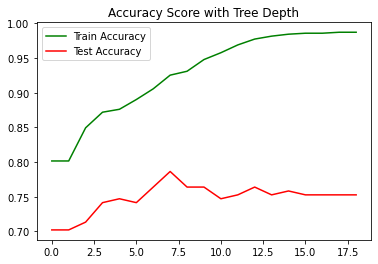

In [41]:
# The accuracy score on both training and testing data improves as the depth goes from 1 to 8.
# When we have the depth more than 8, the model is overfitting.
f, ax = plt.subplots(figsize=(6,4))
plt.plot(tree_train_results, 'g', label = 'Train Accuracy')
plt.plot(tree_test_results, 'r', label = 'Test Accuracy')
plt.legend()
plt.title('Accuracy Score with Tree Depth')
plt.show()

In [42]:
# Let's set max_depth as 8. 
# The accuracy score on testing data is 78.65%, which is higher than what we got from Logistic Regression and KNN. 
decision_tree = DecisionTreeClassifier(random_state=0, max_depth=8)
decision_tree.fit(train_x, train_y)
print("Decision Tree's accuracy on training data is {:.2%}".format(decision_tree.score(train_x, train_y)))
print("Decision Tree's accuracy on testing data is {:.2%}".format(decision_tree.score(test_x, test_y)))
decision_tree_accuracy = round(100*decision_tree.score(test_x, test_y), 2)

Decision Tree's accuracy on training data is 92.55%
Decision Tree's accuracy on testing data is 78.65%


In [43]:
# Next model we will build is Random Forest, which combines many trees and makes predictions by averaging the predictions of each component tree.
# Therefore, it usually has better predictive accuracy than a single decision tree. 
# Let's build a baseline Random Forest model first without tuning any parameters
random_forest = RandomForestClassifier(random_state=0)
random_forest.fit(train_x, train_y)
print("Baseline Random Forest's accuracy on training data is {:.2%}".format(random_forest.score(train_x, train_y)))
print("Baseline Random Forest's accuracy on testing data is {:.2%}".format(random_forest.score(test_x, test_y)))

Baseline Random Forest's accuracy on training data is 98.73%
Baseline Random Forest's accuracy on testing data is 76.40%


In [44]:
# The parameter to tune is n_estimators, which is equal to the number of decision trees in the forest. 
forest_train_results = []
forest_test_results = []
for i in [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]:
    random_forest = RandomForestClassifier(random_state=0, n_estimators=i)
    random_forest.fit(train_x, train_y)
    forest_train_results.append(random_forest.score(train_x, train_y))
    forest_test_results.append(random_forest.score(test_x, test_y))

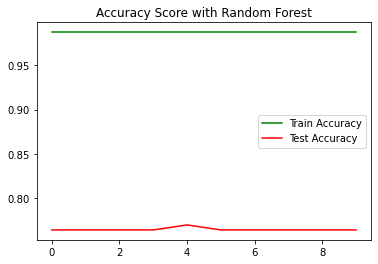

In [45]:
# With n_estimators equal to 500, we get the highest accuracy, so let's set it to 500
f, ax = plt.subplots(figsize=(6,4))
plt.plot(forest_train_results, 'g', label = 'Train Accuracy')
plt.plot(forest_test_results, 'r', label = 'Test Accuracy')
plt.legend()
plt.title('Accuracy Score with Random Forest')
plt.show()

In [46]:
# The accuracy score doesn't change on training data but improved a little bit on testing data compared to baseline Random Forest
random_forest = RandomForestClassifier(random_state=0, n_estimators=500)
random_forest.fit(train_x, train_y)
print("Random Forest's accuracy on training data is {:.2%}".format(random_forest.score(train_x, train_y)))
print("Random Forest's accuracy on testing data is {:.2%}".format(random_forest.score(test_x, test_y)))
random_forest_accuracy = round(100*random_forest.score(test_x, test_y), 2)

Random Forest's accuracy on training data is 98.73%
Random Forest's accuracy on testing data is 76.97%


In [47]:
# The last model we are going to use here is XGBClassifier, which is an implementation of gradient boosting.
# Gradient boosting is an ensemble method that goes through cycles to add models into an ensemble.
# Let's build it up with parameters n_estimators, learning_rate, early_stopping_rounds.
xgb_model = XGBClassifier(n_estimators = 1000, learning_rate = 0.01)
xgb_model.fit(train_x, train_y,
             early_stopping_rounds = 5,
             eval_set=[(test_x, test_y)],
             verbose=False)
print("XGB Classifier's accuracy on training data is {:.2%}".format(xgb_model.score(train_x, train_y)))
print("XGB Classifier's accuracy on testing data is {:.2%}".format(xgb_model.score(test_x, test_y)))
xgb_accuracy = round(100*xgb_model.score(test_x, test_y), 2)

[22:33:06] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGB Classifier's accuracy on training data is 89.59%
XGB Classifier's accuracy on testing data is 77.53%


In [48]:
# Let's build a DataFrame to store the accuracy of each model
# Accuracy of Decision Tree > XGBoost > Random Forest > Logistic Regression > KNN 
model_accuracy = pd.DataFrame({'Model': ['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'XGBoost'],
                              'Accuracy Score': [log_reg_accuracy, knn_accuracy, decision_tree_accuracy, random_forest_accuracy, xgb_accuracy]})
model_accuracy.sort_values(by='Accuracy Score', ascending=False, inplace=True)
model_accuracy

,Model,Accuracy Score
2,Decision Tree,78.65
4,XGBoost,77.53
3,Random Forest,76.97
0,Logistic Regression,75.84
1,KNN,69.66
